## SAGA Paper 4, FIGURE 9:  BPT

In [1]:
import numpy as np
from myplotstyle import plt,get_figsize
%matplotlib inline

from astropy.table import Table
from astropy.io import ascii


from matplotlib import cm
from matplotlib.colors import ListedColormap

import matplotlib
import matplotlib.backends.backend_pdf
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.lines as mlines
import matplotlib.patches as mpatches

from scipy.stats import gaussian_kde

from easyquery import Query, QueryMaker
import SAGA
from SAGA import ObjectCuts as C
from SAGA import HostCuts as H

In [2]:
saga = SAGA.QuickStart()

SAGA `shared_dir` set to /Users/mg37/DropBox/SAGA/
SAGA `local_dir`  set to /Users/mg37/Projects/SAGA/


In [3]:
base = H.paper3.filter(saga.object_catalog.load_combined_base_catalog())
nhosts = len(np.unique(base["HOSTID"]))
assert nhosts == 101

sats = C.is_sat.filter(base)

# LITERATURE AGN DEMARCATION LINES

In [4]:
# KEWLEY 2001, EQ 5 -7 and Figure 16
# https://ui.adsabs.harvard.edu/abs/2001ApJ...556..121K/abstract
x_bpt_kewley01 = np.arange(0,2.5,0.05) - 2.

# [NII]/Halpha
y_bpt_kewley01 = 0.61/(x_bpt_kewley01  - 0.47) +1.19
# [SII]6717+6731 / Halpha
y_SII_kewley01 = 0.72/(x_bpt_kewley01  - 0.32) +1.3
# [OI]6300 / Halpha
y_OI_kewley01 = 0.73/(x_bpt_kewley01  +0.59) +1.33


################
# KAUFFMANN 2003, Eq 1
# https://ui.adsabs.harvard.edu/abs/2003MNRAS.346.1055K/abstract
x_bpt_kauff03 = np.arange(0,2,0.05) - 2.
y_bpt_kauff03 = (0.61 / (x_bpt_kauff03 - 0.05)) + 1.3


######################
#KEWLEY 2006
x_bpt_kewley06 = np.arange(0,2.5,0.05) - 2.
# [SII]6717+6731 / Halpha
y_SII_kewley06 = 0.72/(x_bpt_kewley06  - 0.32) +1.3
y_SII_kewley06b = 1.89/(x_bpt_kewley06  +0.76)


# KEWLEY 2013
z  = 0.008
x_bpt_kewley03 = np.arange(0,2,0.05) - 2.
y_bpt_kewley03 = (0.61 / (x_bpt_kewley03 - 0.02 - (0.1833*z))) + 1.1 + (0.03*z) # redshift dependent, set z above, 0.008 for comparison w saga


### SAGA Satellite with radio continuum source

In [5]:
OBJID_radio = 902799740000002207
mradio = sats['OBJID'] == OBJID_radio

In [6]:
# EKF SATELLITES

ekf = ascii.read('/Users/mg37/Projects/SAGA/SFR_external_cats/satellites_lines_df.csv')

ekf.add_column(0.,name='RA')
ekf.add_column(0.,name='DEC')
ekf.add_column(0.,name='log_sm')
ekf.add_column(0.,name='ssfr')
ekf.add_column(-1.,name='quenched')
ekf.add_column('      ',name='TELNAME')

ssfr = sats['nuv_sfr'] - sats['log_sm']


nmiss=0
for i,obj in enumerate(ekf):
    m=sats['OBJID'] == obj['OBJID']
    if (np.sum(m) ==0):
        nmiss= nmiss+1
        #print(obj['OBJID'])
    if np.sum(m)>0:
        ekf['log_sm'][i] = sats['log_sm'][m]
        ekf['RA'][i] = sats['RA'][m]
        ekf['DEC'][i] = sats['DEC'][m]
        ekf['quenched'][i] = sats['quenched'][m]

        t = sats['TELNAME'][m]
        ekf['TELNAME'][i] = t[0]
        ekf['ssfr'][i] = sats['nuv_sfr'][m] - sats['log_sm'][m] 

m = (ekf['log_sm'] > 0) & (np.isfinite(ekf['F_Halpha_50']))
ekf = ekf[m]
        
mradio=ekf['OBJID'] == OBJID_radio

In [7]:
base = saga.host_catalog.construct_host_query("good").\
                     filter(saga.object_catalog.load_combined_base_catalog())

In [8]:
qlow = Query("SPEC_Z < 0.2","SATS == 0")
lowz = Query(qlow).filter(base, ["nuv_sfr","nuv_sfr_err","nuv_mag_flag" ,"log_sm",'SPEC_Z','RA','DEC','OBJID'])

In [9]:
# EKF BACKGROUND
ekfbg = ascii.read('/Users/mg37/Projects/SAGA/SFR_external_cats/ASB_lines_df.csv')


ekfbg.add_column(0.,name='RA')
ekfbg.add_column(0.,name='DEC')
ekfbg.add_column(0.,name='SPEC_Z')

ekfbg.add_column(0.,name='log_sm')
ekfbg.add_column(0.,name='ssfr')

ssfr = lowz['nuv_sfr'] - lowz['log_sm']

nlz, nmiss = 0, 0
for i,obj in enumerate(ekfbg):
    m=lowz['OBJID'] == obj['OBJID']
    if (np.sum(m) ==0):
        nmiss+=1
#        print(obj['OBJID'])
    if np.sum(m)>0:
        lz=lowz[m]
        
        ekfbg['log_sm'][i] = lz['log_sm'][0]
        ekfbg['RA'][i]     = lz['RA'][0]
        ekfbg['DEC'][i]    = lz['DEC'][0]
        ekfbg['SPEC_Z'][i] = lz['SPEC_Z'][0]
        ekfbg['ssfr'][i]   = lz['nuv_sfr'][0] - lowz['log_sm'][0] 
        
        nlz+=1
print(nlz,nmiss)

26252 2345


In [10]:
sn_n2 = ekfbg['F_[NII]6583_50']/ekfbg['u_F_[NII]6583']
sn_o3 = ekfbg['F_[OIII]5007_50']/ekfbg['u_F_[OIII]5007']
sn_ha = ekfbg['F_Halpha_50']/ekfbg['u_F_Halpha']
sn_hb = ekfbg['F_Hbeta_50']/ekfbg['u_F_Hbeta']
sn_s2 = ekfbg['F_Hbeta_50']/ekfbg['u_F_Hbeta']


snthresh=4
msn_bg = (sn_n2 > snthresh) & (sn_o3 > snthresh) & (sn_ha > snthresh) & (sn_hb > snthresh)  & (sn_s2 > snthresh) 


ekfbg_bpt_x1 = np.log10(ekfbg['F_[NII]6583_50']/ekfbg['F_Halpha_50'])
ekfbg_bpt_y = np.log10(ekfbg['F_[OIII]5007_50']/ekfbg['F_Hbeta_50'])
ekfbg_bpt_x2 = np.log10((ekfbg['F_[SII]6717_50']+ekfbg['F_[SII]6731_50'])/ekfbg['F_Halpha_50'])
ekfbg_bpt_x3 = np.log10(ekfbg['F_[OI]6300_50']/ekfbg['F_Halpha_50'])


logerr_ha = 0.434*ekfbg['u_F_Halpha']/ekfbg['F_Halpha_50']
logerr_n2 = 0.434*ekfbg['u_F_[NII]6583']/ekfbg['F_[NII]6583_50']

logerr_hb = 0.434*ekfbg['u_F_Hbeta']/ekfbg['F_Hbeta_50']
logerr_o3 = 0.434*ekfbg['u_F_[OIII]5007']/ekfbg['F_[OIII]5007_50']

logerr_s2a = 0.434*ekfbg['u_F_[SII]6717']/ekfbg['F_[SII]6717_50']
logerr_s2b = 0.434*ekfbg['u_F_[SII]6731']/ekfbg['F_[SII]6731_50']

ekfbg_bpt_x1_err = np.sqrt(logerr_ha**2 + logerr_n2**2)
ekfbg_bpt_y_err = np.sqrt(logerr_hb**2 + logerr_o3**2)
ekfbg_bpt_x2_err = np.sqrt(logerr_s2a**2 + logerr_s2b**2 + logerr_n2**2)


/var/folders/lh/yw50lcqx1135l567zq_g_0crf3vhm2/T/ipykernel_66118/1854442989.py:12: RuntimeWarning: divide by zero encountered in log10
  ekfbg_bpt_x1 = np.log10(ekfbg['F_[NII]6583_50']/ekfbg['F_Halpha_50'])
/var/folders/lh/yw50lcqx1135l567zq_g_0crf3vhm2/T/ipykernel_66118/1854442989.py:12: RuntimeWarning: invalid value encountered in log10
  ekfbg_bpt_x1 = np.log10(ekfbg['F_[NII]6583_50']/ekfbg['F_Halpha_50'])
/var/folders/lh/yw50lcqx1135l567zq_g_0crf3vhm2/T/ipykernel_66118/1854442989.py:13: RuntimeWarning: divide by zero encountered in log10
  ekfbg_bpt_y = np.log10(ekfbg['F_[OIII]5007_50']/ekfbg['F_Hbeta_50'])
/var/folders/lh/yw50lcqx1135l567zq_g_0crf3vhm2/T/ipykernel_66118/1854442989.py:13: RuntimeWarning: invalid value encountered in log10
  ekfbg_bpt_y = np.log10(ekfbg['F_[OIII]5007_50']/ekfbg['F_Hbeta_50'])
/var/folders/lh/yw50lcqx1135l567zq_g_0crf3vhm2/T/ipykernel_66118/1854442989.py:14: RuntimeWarning: divide by zero encountered in log10
  ekfbg_bpt_x2 = np.log10((ekfbg['F_[SII]

In [11]:
# SN> 4 in all lines
sn_n2 = ekf['F_[NII]6583_50']/ekf['u_F_[NII]6583']
sn_o3 = ekf['F_[OIII]5007_50']/ekf['u_F_[OIII]5007']
sn_ha = ekf['F_Halpha_50']/ekf['u_F_Halpha']
sn_hb = ekf['F_Hbeta_50']/ekf['u_F_Hbeta']
sn_s2a = ekf['F_[SII]6717_50']/ekf['u_F_[SII]6717']
sn_s2b = ekf['F_[SII]6731_50']/ekf['u_F_[SII]6731']


snthresh=3.
msn3 = (sn_n2 > snthresh) & (sn_o3 > snthresh) & (sn_ha > snthresh) & \
        (sn_hb > snthresh) & (sn_s2a > snthresh) & (sn_s2b > snthresh) 

snthresh=4.
msn4 = (sn_n2 >= snthresh) & (sn_o3 >= snthresh) & (sn_ha >= snthresh) & \
        (sn_hb >= snthresh) & (sn_s2a >= snthresh) & (sn_s2b >= snthresh) 

bpt_x1 = np.log10(ekf['F_[NII]6583_50']/ekf['F_Halpha_50'])
bpt_x3 = np.log10(ekf['F_[OI]6300_50']/ekf['F_Halpha_50'])
bpt_x2 = np.log10((ekf['F_[SII]6717_50']+ekf['F_[SII]6731_50'])/ekf['F_Halpha_50'])

bpt_y = np.log10(ekf['F_[OIII]5007_50']/ekf['F_Hbeta_50'])


logerr_ha = 0.434*ekf['u_F_Halpha']/ekf['F_Halpha_50']
logerr_n2 = 0.434*ekf['u_F_[NII]6583']/ekf['F_[NII]6583_50']

logerr_s2a = 0.434*ekf['u_F_[SII]6717']/ekf['F_[SII]6717_50']
logerr_s2b = 0.434*ekf['u_F_[SII]6731']/ekf['F_[SII]6731_50']

logerr_hb = 0.434*ekf['u_F_Hbeta']/ekf['F_Hbeta_50']
logerr_o3 = 0.434*ekf['u_F_[OIII]5007']/ekf['F_[OIII]5007_50']

bpt_x1_err = np.sqrt(logerr_ha**2 + logerr_n2**2)
bpt_x2_err = np.sqrt(logerr_s2a**2 + logerr_s2b**2 + logerr_n2**2)


bpt_y_err = np.sqrt(logerr_hb**2 + logerr_o3**2)

/var/folders/lh/yw50lcqx1135l567zq_g_0crf3vhm2/T/ipykernel_66118/2838920014.py:18: RuntimeWarning: divide by zero encountered in log10
  bpt_x1 = np.log10(ekf['F_[NII]6583_50']/ekf['F_Halpha_50'])
/var/folders/lh/yw50lcqx1135l567zq_g_0crf3vhm2/T/ipykernel_66118/2838920014.py:18: RuntimeWarning: invalid value encountered in log10
  bpt_x1 = np.log10(ekf['F_[NII]6583_50']/ekf['F_Halpha_50'])
/var/folders/lh/yw50lcqx1135l567zq_g_0crf3vhm2/T/ipykernel_66118/2838920014.py:19: RuntimeWarning: divide by zero encountered in log10
  bpt_x3 = np.log10(ekf['F_[OI]6300_50']/ekf['F_Halpha_50'])
/var/folders/lh/yw50lcqx1135l567zq_g_0crf3vhm2/T/ipykernel_66118/2838920014.py:19: RuntimeWarning: invalid value encountered in log10
  bpt_x3 = np.log10(ekf['F_[OI]6300_50']/ekf['F_Halpha_50'])
/var/folders/lh/yw50lcqx1135l567zq_g_0crf3vhm2/T/ipykernel_66118/2838920014.py:20: RuntimeWarning: divide by zero encountered in log10
  bpt_x2 = np.log10((ekf['F_[SII]6717_50']+ekf['F_[SII]6731_50'])/ekf['F_Halpha_5

In [12]:
mz =(ekfbg['SPEC_Z'] < 0.035)  &(ekfbg['SPEC_Z']  > 0) & (ekfbg['log_sm']  < 10)

xs=ekfbg_bpt_x1[mz&msn_bg]
ys=ekfbg_bpt_y[mz&msn_bg]
xs2=ekfbg_bpt_x2[mz&msn_bg]
xs3=ekfbg_bpt_x3[mz&msn_bg]


# SATS
mtel = (ekf['TELNAME'] == 'AAT') | (ekf['TELNAME'] == 'MMT') | (ekf['TELNAME'] == 'GAMA') | (ekf['TELNAME'] == 'SDSS')
mgood4 = (msn4&mtel) | mradio
mgood3 = msn3&mtel

print('Number of satellites SN > 4: ',np.sum(mgood4))
print('Number of satellites 3 > SN 4> : ',np.sum(mgood3&~mgood4))


Number of satellites SN > 4:  110
Number of satellites 3 > SN 4> :  29


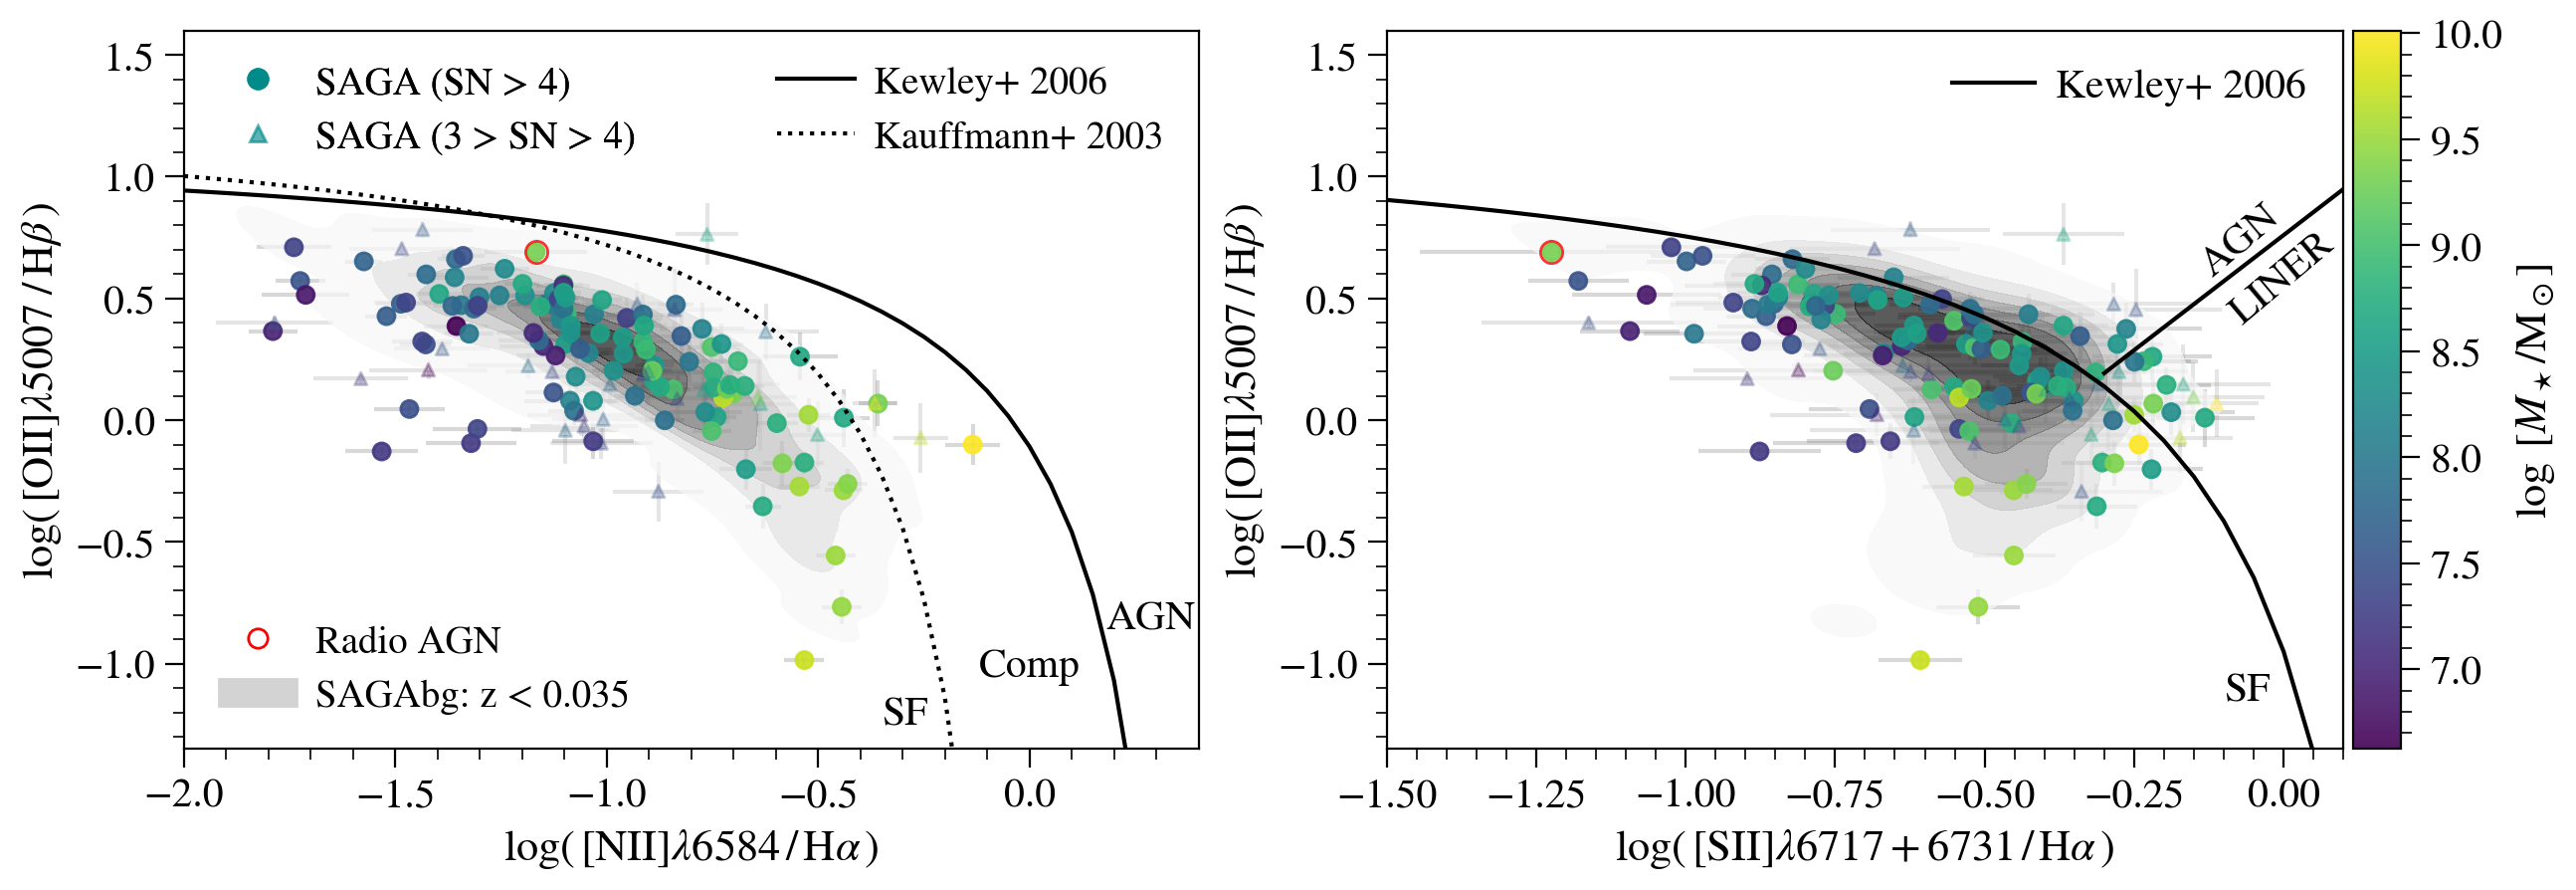

In [13]:
pdf = matplotlib.backends.backend_pdf.PdfPages('figure_BPT.pdf')
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=get_figsize(wide=True, ratio=2.9))

ax1.set_xlim(-2.,0.4)
ax1.set_ylim(-1.35,1.6)
ax2.set_xlim(-1.5,0.1)
ax2.set_ylim(-1.35,1.6)



sz=38
ax1.errorbar(bpt_x1[mgood4],bpt_y[mgood4],fmt='None',xerr = bpt_x1_err[mgood4],\
                                yerr=bpt_y_err[mgood4],c='grey',alpha=0.3,zorder=0)
ax1.scatter(bpt_x1[mgood4],bpt_y[mgood4],c=ekf['log_sm'][mgood4],alpha=0.9,s=sz)



ragn = ax1.plot(bpt_x1[mradio],bpt_y[mradio],'or',alpha=0.8,ms=8,\
                mfc='None',markeredgewidth=1,label='Radio AGN')
ax2.plot(bpt_x2[mradio],bpt_y[mradio],'or',alpha=0.8,ms=8,mfc='None',markeredgewidth=1)


ax1.plot(x_bpt_kewley01, y_bpt_kewley01, c= 'k', label = 'Kewley+ 2006')
ax1.plot(x_bpt_kauff03, y_bpt_kauff03, c= 'k', ls = ':', label = 'Kauffmann+ 2003')

l1 = mlines.Line2D([], [], c='k', label='Kewley+ 2006')
l2 = mlines.Line2D([], [], c='k',ls=':', label='Kauffmann+ 2003')

leg1 = ax1.legend(fontsize=14,loc='upper right',handles=[l1,l2])
ax1.add_artist(leg1)

###########################

ax2.errorbar(bpt_x2[mgood4],bpt_y[mgood4],fmt='None',xerr = bpt_x2_err[mgood4],yerr=bpt_y_err[mgood4],c='grey',alpha=0.3,zorder=0)
bpt2 = ax2.scatter(bpt_x2[mgood4],bpt_y[mgood4],c=ekf['log_sm'][mgood4],alpha=0.9,s=sz)



# PLOT LOWER SN SATELLITES?
bpt3 = ax2.scatter(bpt_x2[mgood3&~mgood4],bpt_y[mgood3&~mgood4],c=ekf['log_sm'][mgood3&~mgood4],alpha=0.3,marker='^',s=20)
bpt3 = ax1.scatter(bpt_x1[mgood3&~mgood4],bpt_y[mgood3&~mgood4],c=ekf['log_sm'][mgood3&~mgood4],alpha=0.3,marker='^',s=20)
ax1.errorbar(bpt_x1[mgood3&~mgood4],bpt_y[mgood3&~mgood4],fmt='None',xerr = bpt_x1_err[mgood3&~mgood4],\
                          yerr=bpt_y_err[mgood3&~mgood4],c='grey',alpha=0.2,zorder=0)
ax2.errorbar(bpt_x2[mgood3&~mgood4],bpt_y[mgood3&~mgood4],fmt='None',xerr = bpt_x2_err[mgood3&~mgood4],\
                          yerr=bpt_y_err[mgood3&~mgood4],c='grey',alpha=0.2,zorder=0)



ax1.set_ylabel(r"$\log(\,{\rm [OII]}\lambda 5007 \; / \, {\rm H}\beta \,$)")

ax1.set_xlabel(r"$\log(\,{\rm [NII]}\lambda 6584 \, / \, {\rm H}\alpha \,$)")

ax2.set_ylabel(r"$\log(\, {\rm [OII]} \lambda 5007 \:/ \, {\rm H}\beta \,$)")

ax2.set_xlabel(r"$\log(\,{\rm[SII]}\lambda 6717 + 6731 \,/\,{\rm H}\alpha \,$)")

# DATA LEGEND
bpatch = mpatches.Patch(color='lightgrey', label='SAGAbg: z < 0.035')#,  M* < $10^{10}M_{\odot}$')

l1 = mlines.Line2D([], [], color='darkcyan', marker='o', ls='', label='SAGA (SN > 4)',ms=7)
l2 = mlines.Line2D([], [], color='darkcyan', marker='^', ls='', label='SAGA (3 > SN > 4)',ms=6,alpha=0.4)

l3 = mlines.Line2D([], [], color='r', marker='o', mfc='None',ls='', label='Radio AGN',ms=7)


leg2 = ax1.legend(fontsize=14,loc='lower left',handles=[l3,bpatch])
leg3 = ax1.legend(fontsize=14,loc='upper left',handles=[l1,l2])

ax1.add_artist(leg2)
ax1.add_artist(leg3)


####################
m=y_SII_kewley01 < 1.5
ax2.plot(x_bpt_kewley01[m], y_SII_kewley01[m], c= 'k', label = 'Kewley+ 2006')
ax2.legend()

x=np.arange(0,1,0.1)-0.3
y = 1.89*x +0.76 
ax2.plot(x,y,'k')


divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(bpt2, cax=cax,label=r'$\log\;[M_\star/{\rm M}_\odot]$')

ax1.text(-0.35,-1.25,'SF')
ax1.text(-0.12,-1.05,'Comp')
ax1.text(0.18,-0.85,'AGN')

ax2.text(-0.1,-1.15,'SF')
ax2.text(-0.1,0.4,'LINER',rotation=40)
ax2.text(-0.15,0.6,'AGN',rotation=40)


# PLOT SAGA bg
X, Y = np.mgrid[-2:0.4:251j, -1.5:1.0:251j]
kernel = gaussian_kde(np.vstack([xs,ys]), 0.3)
Z = np.reshape(kernel(np.vstack([X.ravel(), Y.ravel()])).T, X.shape)
ax1.contourf(X, Y, Z, cmap=plt.cm.Greys, levels=np.linspace(0.1, Z.max(), 8),zorder=0,alpha=0.7)

X, Y = np.mgrid[-2:0.4:251j, -1.5:1.0:251j]
kernel = gaussian_kde(np.vstack([xs2,ys]), 0.3)
Z = np.reshape(kernel(np.vstack([X.ravel(), Y.ravel()])).T, X.shape)
ax2.contourf(X, Y, Z, cmap=plt.cm.Greys, levels=np.linspace(0.1, Z.max(), 8),zorder=0,alpha=0.7)



pdf.savefig()
pdf.close()